In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score, recall_score, accuracy_score, auc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler

# Чистка

In [4]:
test = pd.read_csv('source/test.csv')
train = pd.read_csv('source/train.csv')

In [5]:
test.satisfaction.unique()

array(['satisfied', 'neutral or dissatisfied'], dtype=object)

In [6]:
data = pd.concat([test, train])

In [7]:
data = data.sample(129880 ).reset_index().drop(['index', 'id'], axis=1)

In [8]:
data.isnull().sum()

Unnamed: 0                             0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             393
satisfaction                           0
dtype: int64

In [9]:
data = data.drop(['Unnamed: 0', 'Arrival Delay in Minutes', 'Departure Delay in Minutes'], axis=1)

In [10]:
data.duplicated().sum()

0

# EDA

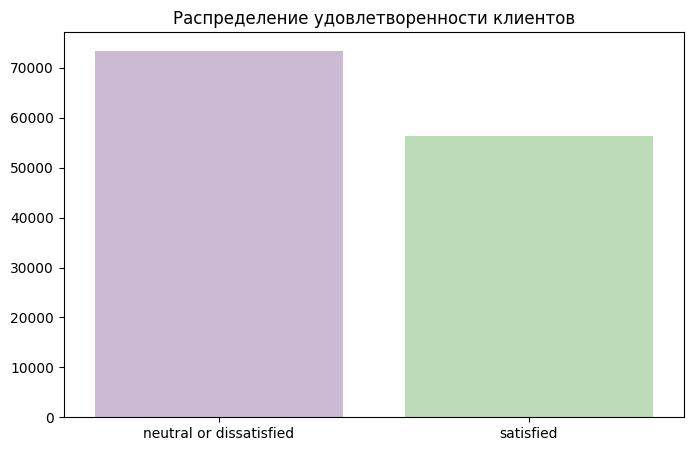

In [11]:
fig = plt.figure(figsize=(8, 5))
sns.countplot(data=data, x='satisfaction', palette='PRGn')
plt.xticks(rotation=0)
plt.xlabel(None)
plt.ylabel(None)
plt.title("Распределение удовлетворенности клиентов")

plt.show()

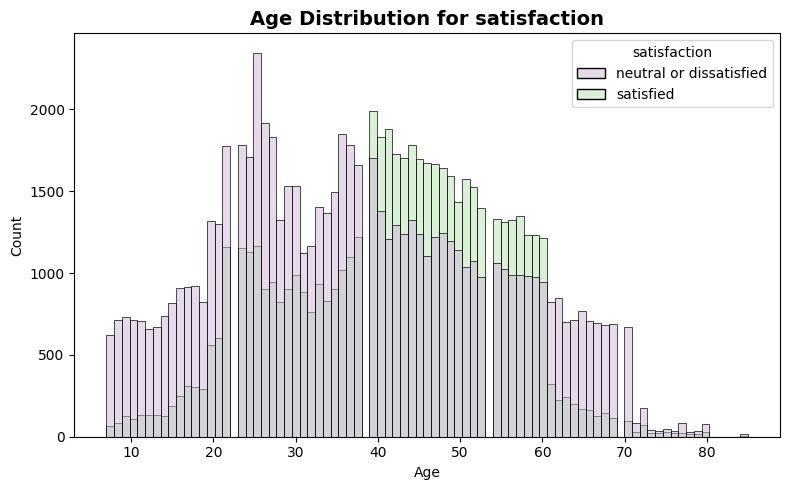

In [12]:
plt.figure(figsize=(8,5))
sns.histplot(x=data['Age'],hue='satisfaction',data=data,palette='PRGn')
plt.title('Age Distribution for satisfaction',fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.tight_layout()
plt.show()

In [13]:
data.columns

Index(['Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class',
       'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'satisfaction'],
      dtype='object')

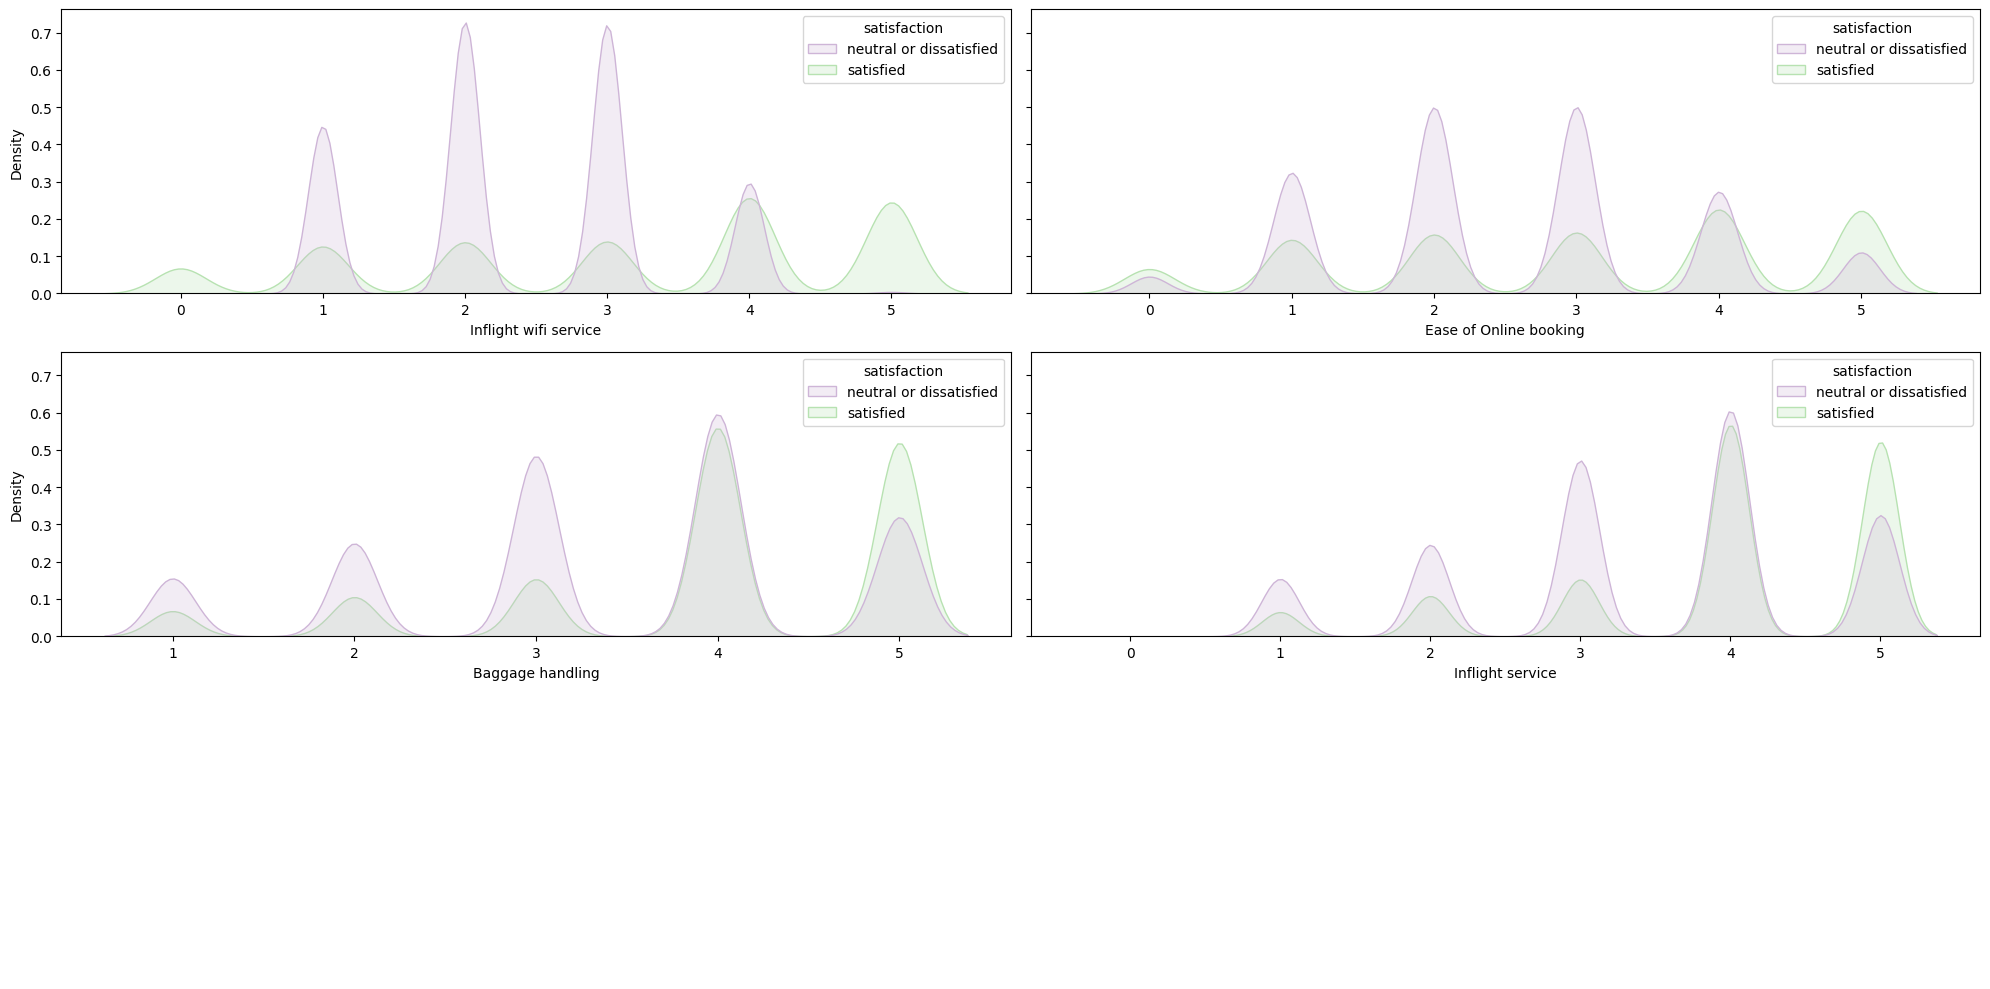

In [17]:
need_cols=data[['Inflight wifi service', 'Ease of Online booking','Baggage handling', 'Inflight service']]
fig ,axs=plt.subplots((len(need_cols.columns)//4)+2,2,figsize=(20,10),sharey=True)
axs=axs.flatten()
for n,i in enumerate(need_cols.columns):
    sns.kdeplot(data=data,x=data[i],hue='satisfaction',ax=axs[n],palette='PRGn',shade=True)
for ax in axs[len(need_cols.columns):]:
    ax.axis('off')
    
plt.tight_layout()   
plt.show()

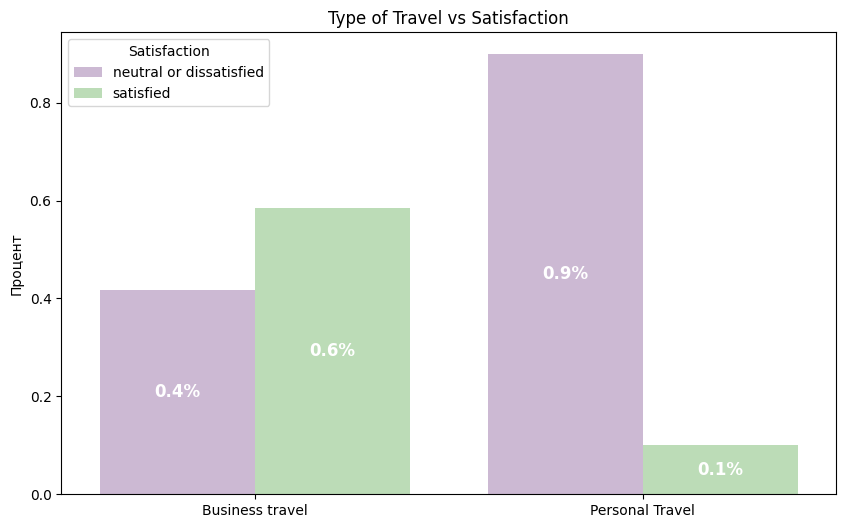

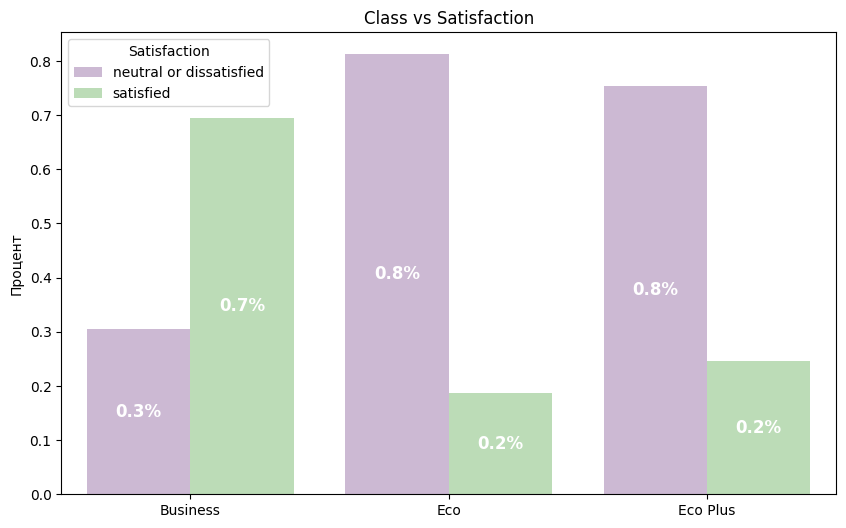

In [21]:
vig_cols = ['Type of Travel', 'Class']

for col in vig_cols:
    plt.figure(figsize=(10, 6))
    
    # Создаем нормализованные проценты для stacked bar chart
    category_counts = data.groupby([col, 'satisfaction']).size().unstack()
    category_percents = category_counts.div(category_counts.sum(axis=1), axis=0).reset_index().melt(id_vars=col)
    
    # Столбчатая диаграмма
    ax = sns.barplot(
        data=category_percents, 
        x=col, 
        y='value', 
        hue='satisfaction', 
        palette='PRGn'
    )
    
    # Добавляем подписи процентов
    for p in ax.patches:
        height = p.get_height()
        if height > 0:  # Избегаем подписей на нулевых значениях
            ax.annotate(f'{height:.1f}%', 
                        (p.get_x() + p.get_width() / 2., p.get_y() + height / 2.), 
                        ha='center', va='center', 
                        fontsize=12, color='white', fontweight='bold')

    plt.title(f'{col} vs Satisfaction')
    plt.ylabel('Процент')
    plt.xlabel('')
    plt.legend(title='Satisfaction')
    plt.show()


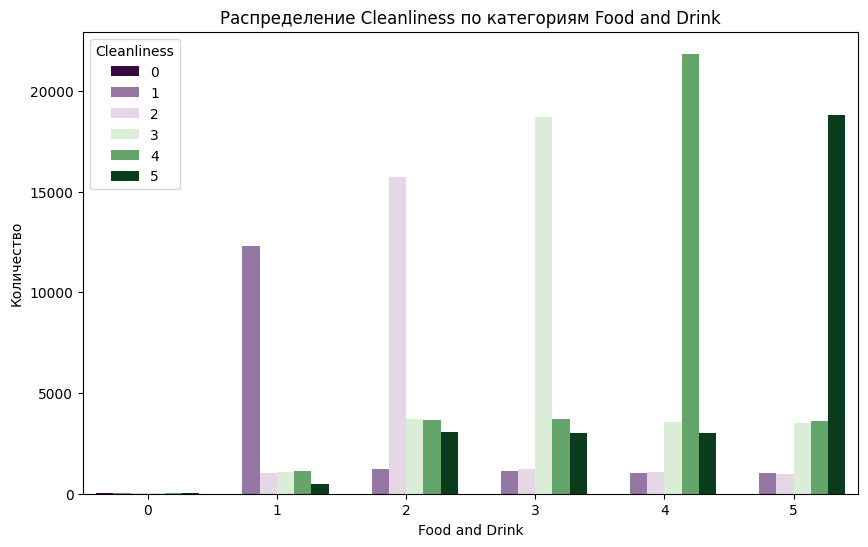

In [66]:
plt.figure(figsize=(10, 6))
sns.countplot(x=data['Food and drink'], hue=data['Cleanliness'], palette='PRGn')
plt.title('Распределение Cleanliness по категориям Food and Drink')
plt.xlabel('Food and Drink')
plt.ylabel('Количество')
plt.legend(title='Cleanliness')
plt.show()


---

# ML AAAAAAAAAAAAAAAAA

In [22]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['satisfaction'] = le.fit_transform(data['satisfaction'])
data['Class'] = le.fit_transform(data['Class'])
data['Type of Travel'] = le.fit_transform(data['Type of Travel'])
data['Customer Type'] = le.fit_transform(data['Customer Type'])
data['Gender'] = le.fit_transform(data['Gender'])


## Отбор признаков

In [23]:
data.corrwith(data['satisfaction']).sort_values()

Type of Travel                      -0.449861
Class                               -0.448193
Customer Type                       -0.186017
Departure/Arrival time convenient   -0.054270
Gate location                       -0.002793
Gender                               0.011236
Age                                  0.134091
Ease of Online booking               0.168877
Food and drink                       0.211340
Checkin service                      0.237252
Inflight service                     0.244918
Baggage handling                     0.248680
Inflight wifi service                0.283460
Flight Distance                      0.298085
Cleanliness                          0.307035
Leg room service                     0.312424
On-board service                     0.322205
Seat comfort                         0.348829
Inflight entertainment               0.398234
Online boarding                      0.501749
satisfaction                         1.000000
dtype: float64

In [24]:
# X = data[['Online boarding', 'Type of Travel', 'Class', 'Inflight entertainment','Seat comfort']]
X = data[[
'Inflight entertainment',
'Seat comfort',
'On-board service',
'Cleanliness',
'Leg room service',
'Inflight wifi service',
'Baggage handling',
'Checkin service',
'Food and drink',
'Type of Travel']]
y = data['satisfaction']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [26]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [27]:
logistic = LogisticRegression(max_iter=565)
logistic.fit(X_train, y_train)


LogisticRegression(max_iter=565)

In [28]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=3)

In [29]:
des_tree = DecisionTreeClassifier(max_depth=5)
des_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

In [30]:
from lightgbm import LGBMClassifier
lgbm_model = LGBMClassifier(verbose=-200)
lgbm_model.fit(X_train, y_train)


LGBMClassifier(verbose=-200)

# Метрики

In [31]:
y_proba_log = logistic.predict_proba(X_test)[:, 1]
y_proba_knn= knn.predict_proba(X_test)[:, 1]
y_proba_tree = des_tree.predict_proba(X_test)[:, 1]
y_proba_lgnm = lgbm_model.predict_proba(X_test)[:, 1]

In [32]:
fpr_log, tpr_log, _ = roc_curve(y_test, y_proba_log)
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_proba_knn)
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_proba_tree)
fpr_lgnm, tpr_lgnm, _ = roc_curve(y_test, y_proba_lgnm)

In [33]:
roc_auc_log = auc(fpr_log, tpr_log)
roc_auc_knn = auc(fpr_knn, tpr_knn)
roc_auc_tree = auc(fpr_tree, tpr_tree)
roc_auc_lgbm = auc(fpr_lgnm, tpr_lgnm)

NameError: name 'auc' is not defined

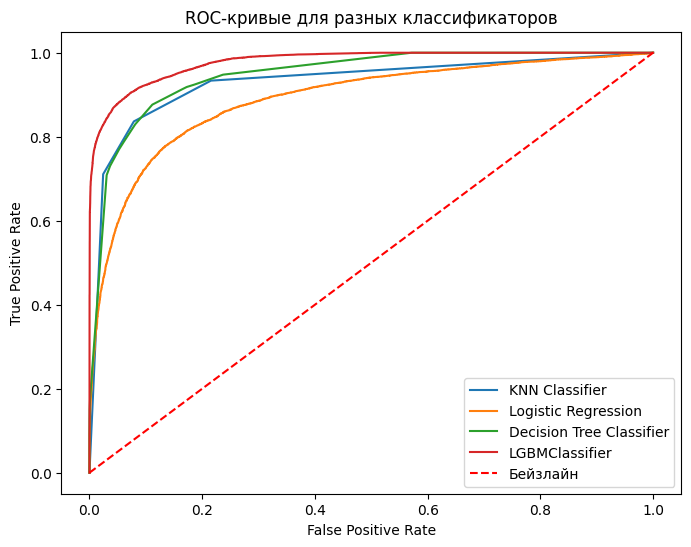

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(fpr_knn, tpr_knn, label="KNN Classifier")
plt.plot(fpr_log, tpr_log, label="Logistic Regression")
plt.plot(fpr_tree, tpr_tree, label="Decision Tree Classifier")
plt.plot(fpr_lgnm, tpr_lgnm, label="LGBMClassifier")

plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Бейзлайн')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривые для разных классификаторов")
plt.legend()
plt.show()

In [ ]:
y_proba_log = logistic.predict_proba(X_test)[:, 1]
y_proba_knn= knn.predict_proba(X_test)[:, 1]
y_proba_tree = des_tree.predict_proba(X_test)[:, 1]
y_proba_lgnm = lgbm_model.predict_proba(X_test)[:, 1]

In [34]:
cv_scores_knn = cross_val_score(knn, X, y, cv=5, scoring='recall')
cv_scores_knn_mean = cv_scores_knn.mean().round(2)
cv_scores_knn_std = cv_scores_knn.std().round(4)

In [35]:
cv_scores_log = cross_val_score(logistic, X, y, cv=5, scoring='recall')
cv_scores_log_mean = cv_scores_log.mean().round(2)
cv_scores_log_std = cv_scores_log.std().round(4)

In [36]:
cv_score_tree = cross_val_score(des_tree, X, y, cv=5, scoring='recall')
cv_scores_tree_mean = cv_score_tree.mean().round(2)
cv_scores_tree_std = cv_score_tree.std().round(4)

In [37]:
cv_scores_lgbm = cross_val_score(lgbm_model, X, y, cv=5, scoring='recall')
cv_scores_lgbm_mean = cv_scores_lgbm.mean().round(2)
cv_scores_lgbm_std = cv_scores_lgbm.std().round(4)

In [38]:
results = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Decision Tree', 'LGBM'],
    'Mean Recall': [cv_scores_knn_mean, cv_scores_log_mean, cv_scores_tree_mean, cv_scores_lgbm_mean],
    'Recall Std Dev': [cv_scores_knn_std, cv_scores_log_std, cv_scores_tree_std, cv_scores_lgbm_std]
})

results

                 Model  Mean Recall  Recall Std Dev
0                  KNN         0.86          0.0010
1  Logistic Regression         0.80          0.0021
2        Decision Tree         0.86          0.0109
3                 LGBM         0.89          0.0014


In [47]:
y_proba_knn_train = knn.predict_proba(X_train)[:, 1]
y_proba_knn_test = knn.predict_proba(X_test)[:, 1]

y_proba_log_train = logistic.predict_proba(X_train)[:, 1]
y_proba_log_test = logistic.predict_proba(X_test)[:, 1]

y_proba_tree_train = des_tree.predict_proba(X_train)[:, 1]
y_proba_tree_test = des_tree.predict_proba(X_test)[:, 1]

y_proba_lgbm_train = lgbm_model.predict_proba(X_train)[:, 1]
y_proba_lgbm_test = lgbm_model.predict_proba(X_test)[:, 1]

In [94]:
roc_auc_test_knn = roc_auc_score(y_test, y_proba_knn_test)
roc_auc_train_knn = roc_auc_score(y_train, y_proba_knn_train)

roc_auc_test_log = roc_auc_score(y_test, y_proba_log_test)
roc_auc_train_log = roc_auc_score(y_train, y_proba_log_train)

roc_auc_test_tree = roc_auc_score(y_test, y_proba_tree_test)
roc_auc_train_tree = roc_auc_score(y_train, y_proba_tree_train)

roc_auc_test_lgbm = roc_auc_score(y_test, y_proba_lgbm_test) 
roc_auc_train_lgbm = roc_auc_score(y_train, y_proba_lgbm_train)

In [49]:
logistic_accuracy_train = accuracy_score(y_train, logistic.predict(X_train))
logistic_recall_train = recall_score(y_train, logistic.predict(X_train))
logistic_accuracy_test = accuracy_score(y_test, logistic.predict(X_test))
logistic_recall_test = recall_score(y_test, logistic.predict(X_test))

knn_accuracy_train = accuracy_score(y_train, knn.predict(X_train))
knn_recall_train = recall_score(y_train, knn.predict(X_train))
knn_accuracy_test = accuracy_score(y_test, knn.predict(X_test))
knn_recall_test = recall_score(y_test, knn.predict(X_test))

des_tree_accuracy_train = accuracy_score(y_train, des_tree.predict(X_train))
des_tree_recall_train = recall_score(y_train, des_tree.predict(X_train))
des_tree_accuracy_test = accuracy_score(y_test, des_tree.predict(X_test))
des_tree_recall_test = recall_score(y_test, des_tree.predict(X_test))

lgbm_accuracy_train = accuracy_score(y_train, lgbm_model.predict(X_train))
lgbm_recall_train = recall_score(y_train, lgbm_model.predict(X_train))
lgbm_accuracy_test = accuracy_score(y_test, lgbm_model.predict(X_test))
lgbm_recall_test = recall_score(y_test, lgbm_model.predict(X_test))


In [103]:
metrics_dict = {
    'Model': ['Logistic Regression', 'K-Nearest Neighbors (KNN)', 'Decision Tree', 'LightGBM (LGBM)'],
    'Accuracy (Test)': [logistic_accuracy_test, knn_accuracy_test, des_tree_accuracy_test, lgbm_accuracy_test],
    'Accuracy (Train)': [logistic_accuracy_train, knn_accuracy_train, des_tree_accuracy_train, lgbm_accuracy_train],
    'Recall (Test)': [logistic_recall_test, knn_recall_test, des_tree_recall_test, lgbm_recall_test],
    'Recall (Train)': [logistic_recall_train, knn_recall_train, des_tree_recall_train, lgbm_recall_train],
    'ROC AUC (Test)': [roc_auc_test_log, roc_auc_test_knn, roc_auc_test_tree, roc_auc_test_lgbm],
    'ROC AUC (Train)': [roc_auc_train_log, roc_auc_train_knn, roc_auc_train_tree, roc_auc_train_lgbm]
}

metrics_df = pd.DataFrame(metrics_dict)
metrics_df = metrics_df.round(2)
metrics_df

,Model,Accuracy (Test),Accuracy (Train),Recall (Test),Recall (Train),ROC AUC (Test),ROC AUC (Train)
0,Logistic Regression,0.82,0.83,0.80,0.80,0.89,0.89
1,K-Nearest Neighbors (KNN),0.88,0.92,0.84,0.89,0.93,0.97
2,Decision Tree,0.88,0.88,0.88,0.88,0.95,0.95
3,LightGBM (LGBM),0.92,0.92,0.89,0.89,0.98,0.98


In [98]:
feature_names = [
'Inflight entertainment',
'Seat comfort',
'On-board service',
'Cleanliness',
'Leg room service',
'Inflight wifi service',
'Baggage handling',
'Checkin service',
'Food and drink','Ease of Online booking']

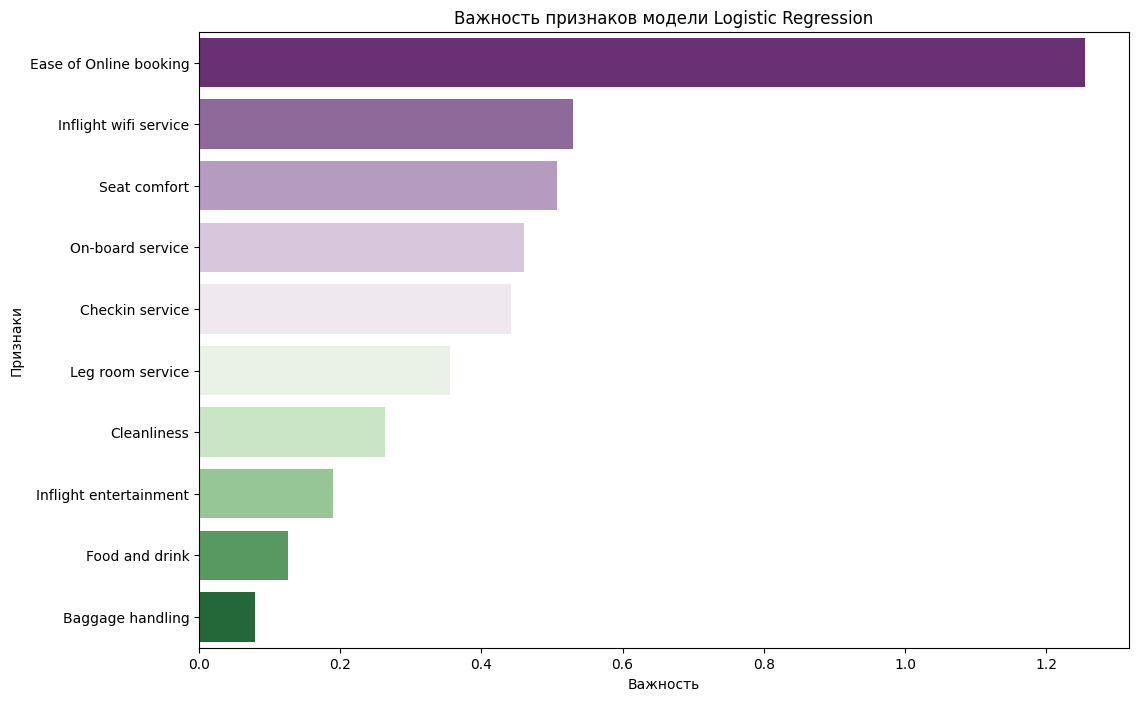

In [100]:
coefs = logistic.coef_[0]
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': np.abs(coefs)})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(
    data=importance_df, 
    x='Importance', 
    y='Feature', 
    palette='PRGn')

plt.xlabel('Важность')
plt.ylabel('Признаки')
plt.title('Важность признаков модели Logistic Regression')

plt.show()


Text(0.5, 1.0, 'Важность признаков модели lgbm_model')

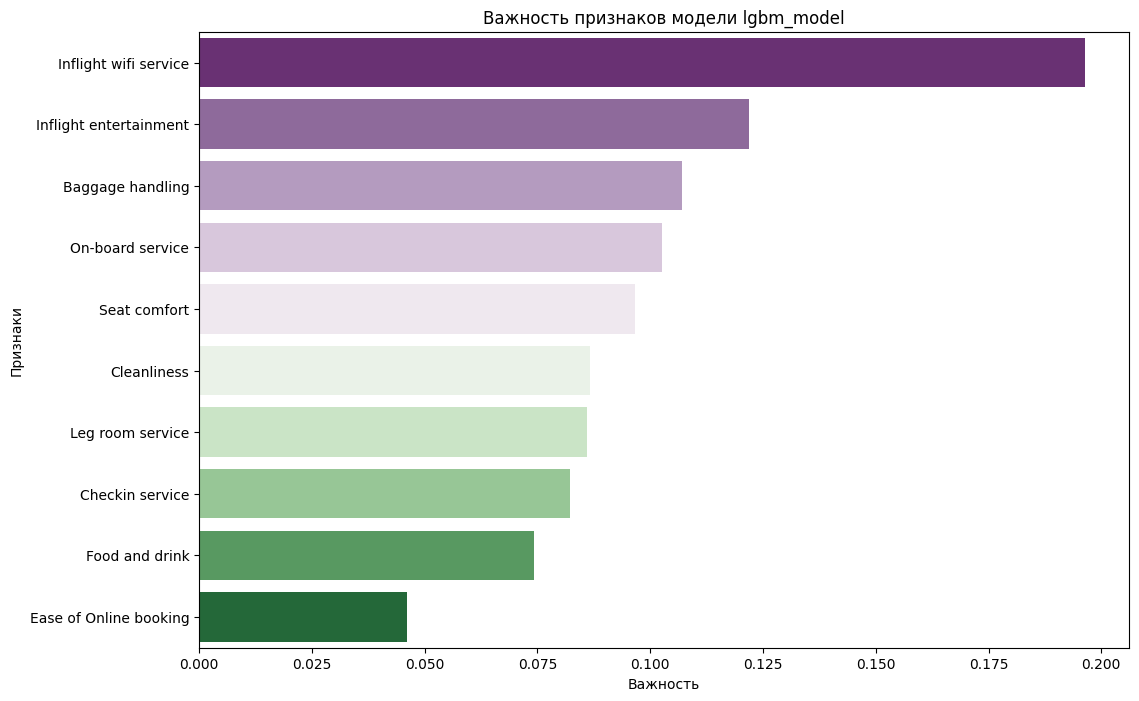

In [87]:
importances = lgbm_model.feature_importances_
importances_normalized = importances / importances.sum()

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances_normalized})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(
    data=importance_df, 
    x='Importance', 
    y='Feature', 
    palette='PRGn'  
)

plt.xlabel('Важность')
plt.ylabel('Признаки')
plt.title('Важность признаков модели lgbm_model')

Text(0.5, 1.0, 'Важность признаков модели des_tree')

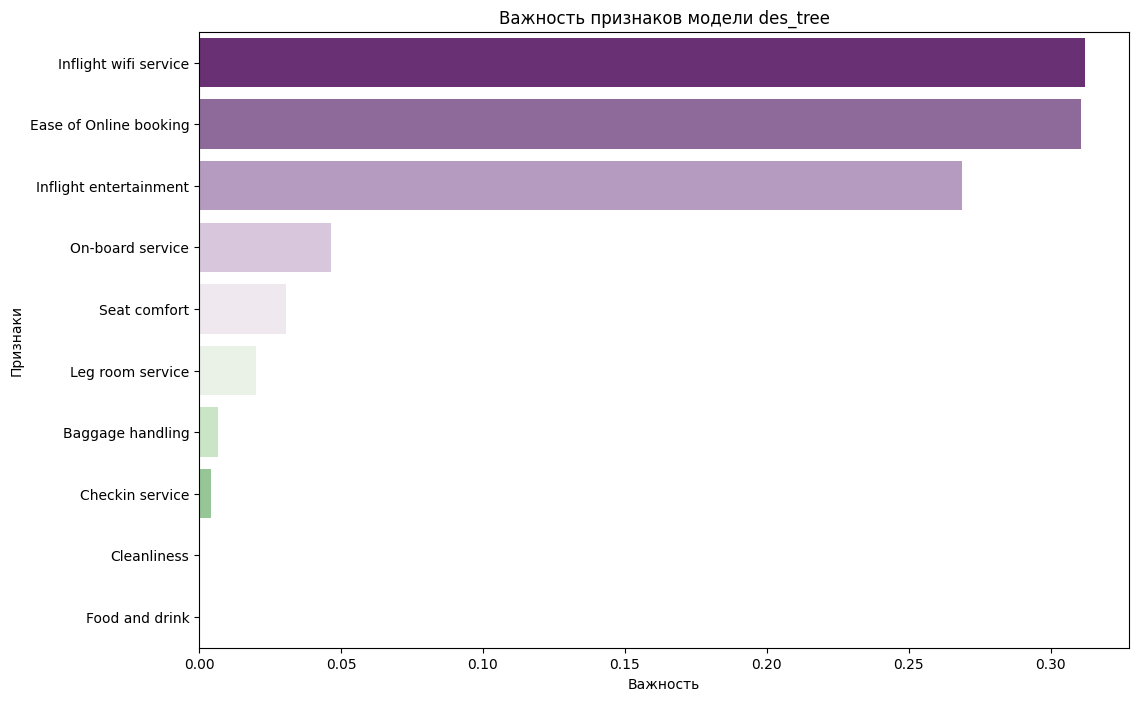

In [101]:


# Получаем важность признаков
importances = des_tree.feature_importances_
 # Признаки, которые использовались

# Создаем DataFrame с важностью признаков
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(
    data=importance_df, 
    x='Importance', 
    y='Feature', 
    palette='PRGn'  
)

plt.xlabel('Важность')
plt.ylabel('Признаки')
plt.title('Важность признаков модели des_tree')


---

In [46]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [47]:
param_grid = {
    'n_neighbors': [3, 5, 7, 11, 15],
    'weights':['uniform', 'distance'],
    'metric': ['minkowski', 'euclidean', 'manhattan']
}

grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=3,            
    scoring='accuracy',
    n_jobs=-1        
)

grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучшее качество (cv):", grid_search.best_score_)

best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Точность на тестовой выборке:", test_accuracy)

Лучшие параметры: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
Лучшее качество (cv): 0.9146683269910104
Точность на тестовой выборке: 0.9174358974358975


In [54]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty':['l1', 'l2'],
    'solver': ['lbfgs', 'liblinear']
}

grid_search = GridSearchCV(
    estimator=logistic,
    param_grid=param_grid,
    cv=3,            
    scoring='accuracy',
    n_jobs=-1        
)

grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучшее качество (cv):", grid_search.best_score_)

best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Точность на тестовой выборке:", test_accuracy)

Лучшие параметры: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Лучшее качество (cv): 0.875522987654966
Точность на тестовой выборке: 0.8738461538461538


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\user\AppData\Lo

In [55]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'ccp_alpha': [0.0, 0.01, 0.1]
}


grid_search = GridSearchCV(
    estimator=des_tree,
    param_grid=param_grid,
    cv=3,            
    scoring='accuracy',
    n_jobs=-1        
)

grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучшее качество (cv):", grid_search.best_score_)

best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Точность на тестовой выборке:", test_accuracy)

Лучшие параметры: {'ccp_alpha': 0.0, 'criterion': 'entropy', 'max_depth': 7, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 10}
Лучшее качество (cv): 0.9302845192170932
Точность на тестовой выборке: 0.9312820512820513


In [16]:
data.satisfaction.value_counts(normalize=True)

satisfaction
0    0.570571
1    0.429429
Name: proportion, dtype: float64


- https://www.kaggle.com/code/adityayadav01/will-the-passenger-be-satisfied
- https://www.kaggle.com/code/manarmohamed24/airline-passenger-satisfaction-acc-95-7
- https://www.kaggle.com/code/elkadaouisouhaila/airline-passenger-satisfaction-auc-96
- https://www.kaggle.com/code/marwaabuelkheir/airline-passenger-satisfaction-analysis
- https://www.kaggle.com/code/mariamyasser44/airline-eda
- https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction/code


---
# Кластеризация

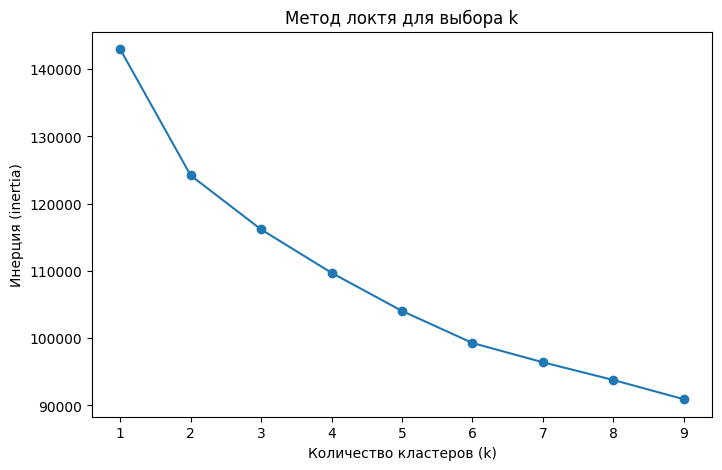

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

# Кодирование категориальных признаков
label_encoders = {}
categorical_cols = ['Gender', 'Customer Type', 'Type of Travel', 'Class']

for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Масштабирование данных
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Определение оптимального числа кластеров методом локтя
inertia = []
k_range = range(1, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Визуализация метода локтя
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o', linestyle='-')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Инерция (inertia)')
plt.title('Метод локтя для выбора k')
plt.show()


In [13]:
data = data.drop(['satisfaction'], axis=1)

In [18]:
data = data.drop(['Arrival Delay in Minutes'], axis=1)

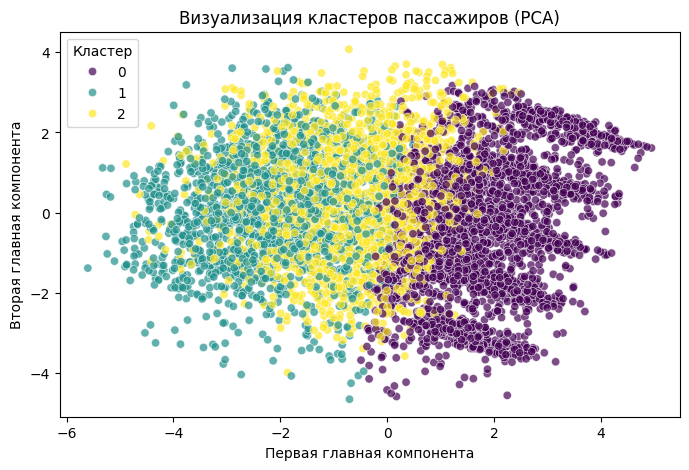

,Unnamed: 0,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,satisfaction_enc,PCA1,PCA2
Cluster,,,,,,,,,,,,,,,,,,,,,
0,43560.949577,0.474420,0.121457,41.477365,0.198749,0.303276,1506.398601,3.085388,3.244019,3.026868,...,4.175929,3.988222,4.313949,3.801619,4.339713,4.000736,12.793890,1.0,1.876801,-0.283195
1,45644.253740,0.541427,0.343498,32.928654,0.434407,0.882624,815.922900,2.227848,3.025316,2.428654,...,3.244534,3.261220,3.659379,3.088032,3.719217,1.836594,17.984465,1.0,-2.097202,0.051416
2,43433.243879,0.435847,0.167973,41.511263,0.358962,0.792850,1003.844760,2.615083,2.881978,2.653281,...,2.400588,2.526934,2.603330,2.791871,2.593536,3.578844,14.105779,1.0,-0.712209,0.333046


In [20]:
# Применение K-Means с k=3
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
data['Cluster'] = kmeans.fit_predict(scaled_data)

# PCA для визуализации кластеров (уменьшение размерности до 2D)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)
data['PCA1'] = pca_result[:, 0]
data['PCA2'] = pca_result[:, 1]

# Визуализация кластеров
plt.figure(figsize=(8, 5))
sns.scatterplot(x='PCA1', y='PCA2', hue=data['Cluster'], palette='viridis', data=data, alpha=0.7)
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.title('Визуализация кластеров пассажиров (PCA)')
plt.legend(title='Кластер')
plt.show()

# Анализ средних значений признаков по кластерам
cluster_analysis = data.groupby('Cluster').mean()
cluster_analysis
